In [1]:
import pm4py
import pymc3 as pm
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from fitter import Fitter, get_distributions, get_common_distributions
from hmmlearn import hmm


from queue_model import Queue
from queue_adapter import derive_from_dfg

%matplotlib inline
plt.rcParams['figure.figsize'] = [9, 5]

%load_ext autoreload
%aimport queue_model
%aimport queue_adapter
%autoreload 1

%config InlineBackend.figure_format = 'retina'


Bad key "text.kerning_factor" on line 4 in
C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
from pm4py.objects.log.importer.xes import factory as xes_import_factory
log = xes_import_factory.apply("C:/Users/Daniel/Documents/Event logs/RequestForPayment.xes.gz")

In [3]:
from pm4py.statistics.traces.log import case_statistics

var_with_count = case_statistics.get_variant_statistics(log, parameters={"max_variants_to_return": 5})
var_with_count

[{'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by ADMINISTRATION,Request For Payment FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled',
  'count': 3011},
 {'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by ADMINISTRATION,Request For Payment APPROVED by BUDGET OWNER,Request For Payment FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled',
  'count': 1762},
 {'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled',
  'count': 583},
 {'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment REJECTED by ADMINISTRATION,Request For Payment REJECTED by EMPLOYEE',
  'count': 343},
 {'variant': 'Request For Payment SUBMITTED by EMPLOYEE,Request For Payment APPROVED by PRE_APPROVER,Request For Payment FINAL_APPROVED by SUPERVISOR,Request Payment,Payment Handled',
  'count': 340}]

In [4]:
from pm4py.algo.filtering.log.variants import variants_filter

filtered_log = variants_filter.filter_log_variants_percentage(log, percentage=.8)

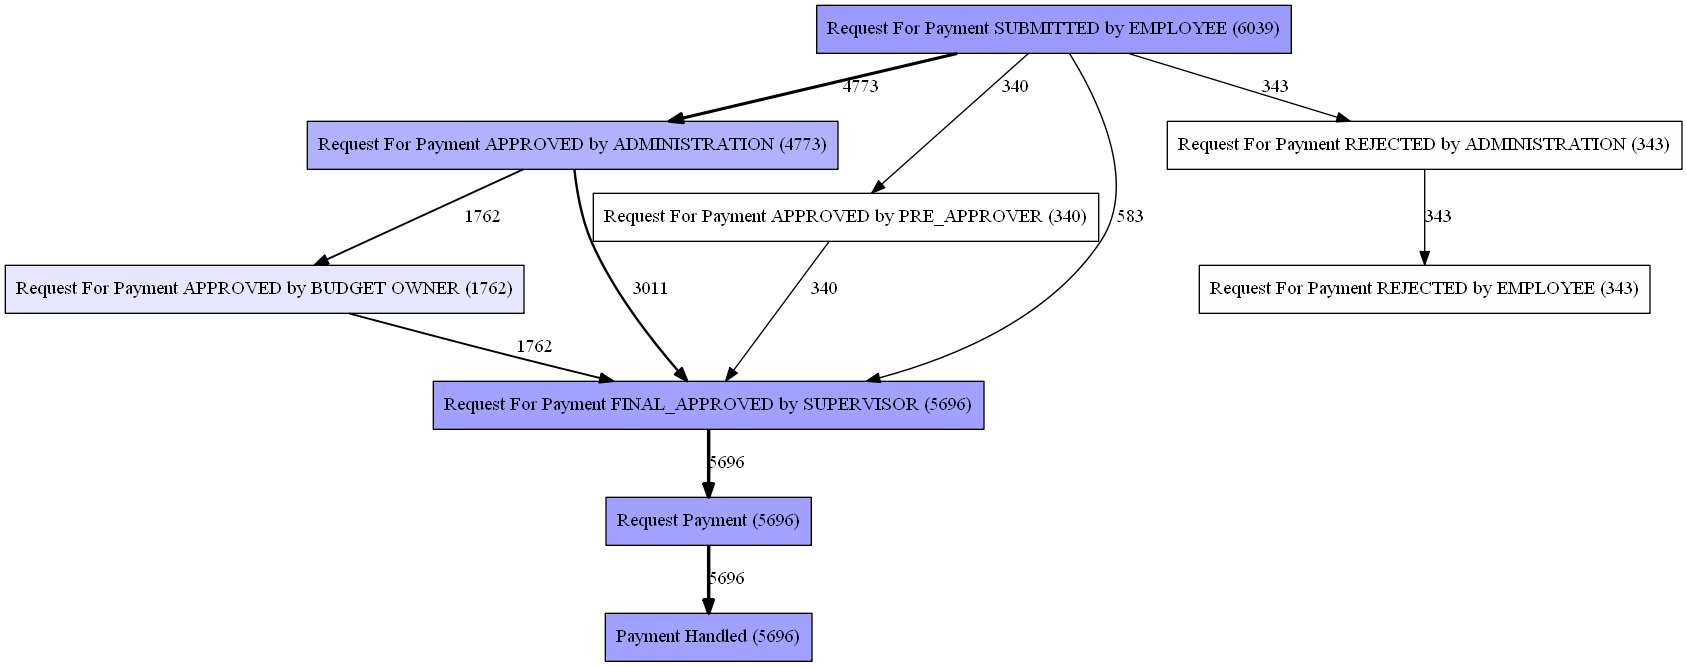

In [40]:
from pm4py.algo.discovery.dfg import factory as dfg_miner
from pm4py.visualization.dfg import factory as dfg_vis

dfg = dfg_miner.apply(filtered_log)
dfg_gviz = dfg_vis.apply(dfg, filtered_log)
dfg_vis.view(dfg_gviz)

In [41]:
def get_dfg_activities(dfg):
    result = set()
    for v, w in dfg.keys():
        result.add(v)
        result.add(w)
    return list(result)

In [42]:
activities = get_dfg_activities(dfg)
activities

['Request For Payment FINAL_APPROVED by SUPERVISOR',
 'Request Payment',
 'Request For Payment REJECTED by ADMINISTRATION',
 'Payment Handled',
 'Request For Payment APPROVED by BUDGET OWNER',
 'Request For Payment APPROVED by PRE_APPROVER',
 'Request For Payment SUBMITTED by EMPLOYEE',
 'Request For Payment REJECTED by EMPLOYEE',
 'Request For Payment APPROVED by ADMINISTRATION']

In [43]:
from pm4py.objects.log.util.log import get_event_labels
from pm4py.util import xes_constants

# activities = get_event_labels(filtered_log, key=xes_constants.DEFAULT_NAME_KEY)
# activities

In [44]:
queues = derive_from_dfg(filtered_log, dfg, activities)

In [45]:
def ecdf(x):
    x_ = np.sort(x)
    n = len(x)
    y_ = np.arange(1, n+1) / n
    plt.plot(x_, y_, marker='.')

In [46]:
def cut_to_90(s):
    low, high = np.percentile(s, [5, 95])
    print(low, high)
    return s[(low <= s) & (s <= high)]

In [47]:
def dist_fitter(vals):
    f = Fitter(vals, distributions=get_common_distributions())
    f.fit()
    print(f.summary())
    pois = sm.Poisson(vals, np.ones_like(vals)).fit()
    print(pois.summary())

In [48]:
def do_hmm(vals, num_states=2):
    vals = np.reshape(vals, (-1, 1))
    ghm = hmm.GaussianHMM(n_components=num_states, n_iter=100).fit(vals)
    score, hidden_states = ghm.decode(vals)
    print('log likelihood', score)
    idx = np.argsort(np.squeeze(ghm.means_))
    hidden_states = np.array(list(map(lambda i: idx[i], hidden_states)))
    plt.plot(vals)
    plt.twinx()
    plt.plot(hidden_states, color='red')

In [49]:
def vis_queue(q: Queue):
    print('Replaying Queue', q.name)
    queue_history, timestamps = q.replay_queue()

    if len(queue_history) > 0:
        plt.plot(timestamps, queue_history)
        plt.title(q.name)
        plt.gcf().autofmt_xdate()
        plt.show()

In [50]:
def vis_iat(q: Queue):
    print('Replaying Queue', q.name)
    ia = q.get_interarrivals()
    if not ia.empty:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.distplot(ia.entries)
        plt.title('inter arrival of entries')
        plt.subplot(122)
        sns.distplot(ia.exits)
        plt.title('inter arrival of exits')
        plt.show()

In [51]:
def vis_waits(q: Queue):
    print('Replaying Queue', q.name)
    df = q.get_data()
    if not df.waits.empty:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        sns.distplot(df.waits)
        plt.title('wait distribution')
        plt.subplot(122)
        waits_ts = pd.Series(index=pd.DatetimeIndex(pd.to_datetime(df.exits, utc=True)), data=df.waits.values)
        waits_ts.sort_index(inplace=True)
        plt.plot(waits_ts)
        plt.gcf().autofmt_xdate()
        plt.show()

In [52]:
def fit_iat(q: Queue):
    print('Replaying Queue', q.name)
    df = q.get_interarrivals()
    if not df.empty:
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        dist_fitter(df.entries.astype('timedelta64[s]').values)
        plt.subplot(122)
        dist_fitter(df.exits.astype('timedelta64[s]').values)
        plt.show()


In [53]:
def fit_waits(q: Queue):
    print('Replaying Queue', q.name)
    df = q.get_data()
    if not df.waits.empty:
        dist_fitter(df.waits.astype('timedelta64[s]').values)
        plt.show()
        

In [54]:
def agg_hmm(q: Queue, freq='W'):
    df = q.get_data()
    if not df.empty:
        entry_ts = pd.DataFrame(index=pd.DatetimeIndex(pd.to_datetime(df.entries, utc=True)), data={'sources': df.sources.values}).groupby(pd.Grouper(freq=freq)).size()
        entry_ts.sort_index(inplace=True)
        exits_ts = pd.DataFrame(index=pd.DatetimeIndex(pd.to_datetime(df.exits, utc=True)), data={'resources': df.resources.values}).groupby(pd.Grouper(freq=freq)).size()
        exits_ts.sort_index(inplace=True)
        plt.figure(figsize=(15,5))
        plt.subplot(121)
        do_hmm(entry_ts.values)
        plt.subplot(122)
        do_hmm(exits_ts.values)
        plt.show()
    

Replaying Queue Request For Payment REJECTED by ADMINISTRATION
Q_gt1 172
fifo 4 0.023255813953488372
lifo 165 0.9593023255813954
fifo-lifo cont 0.9704457364341085
dequeue positions std 0.15762364910039298
spt 169 0.9825581395348837
spt cont 0.9937015503875969


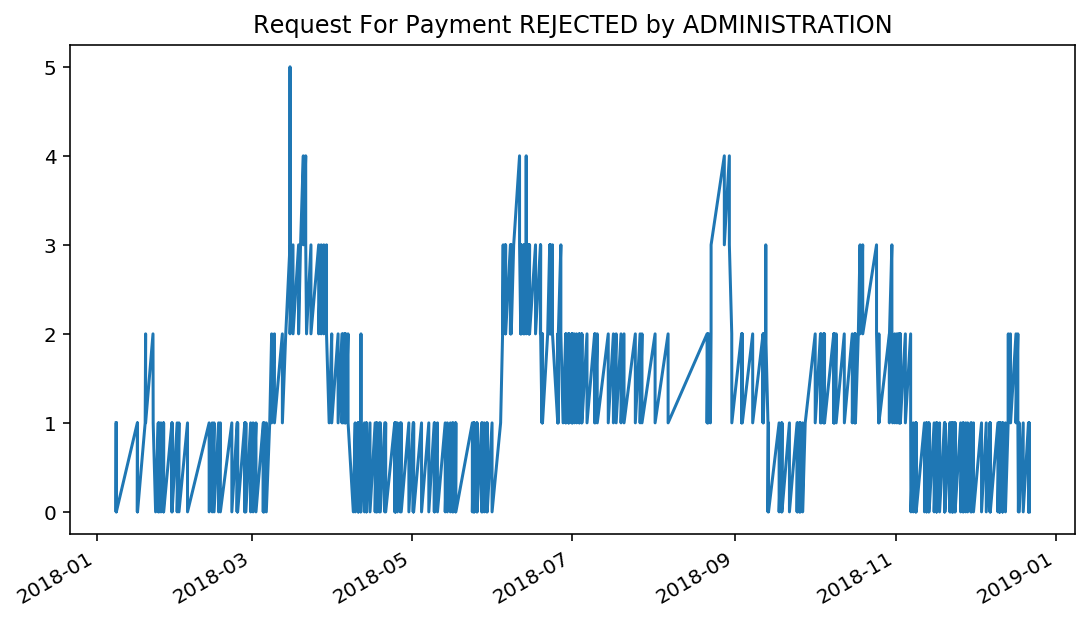

Replaying Queue Request For Payment REJECTED by ADMINISTRATION


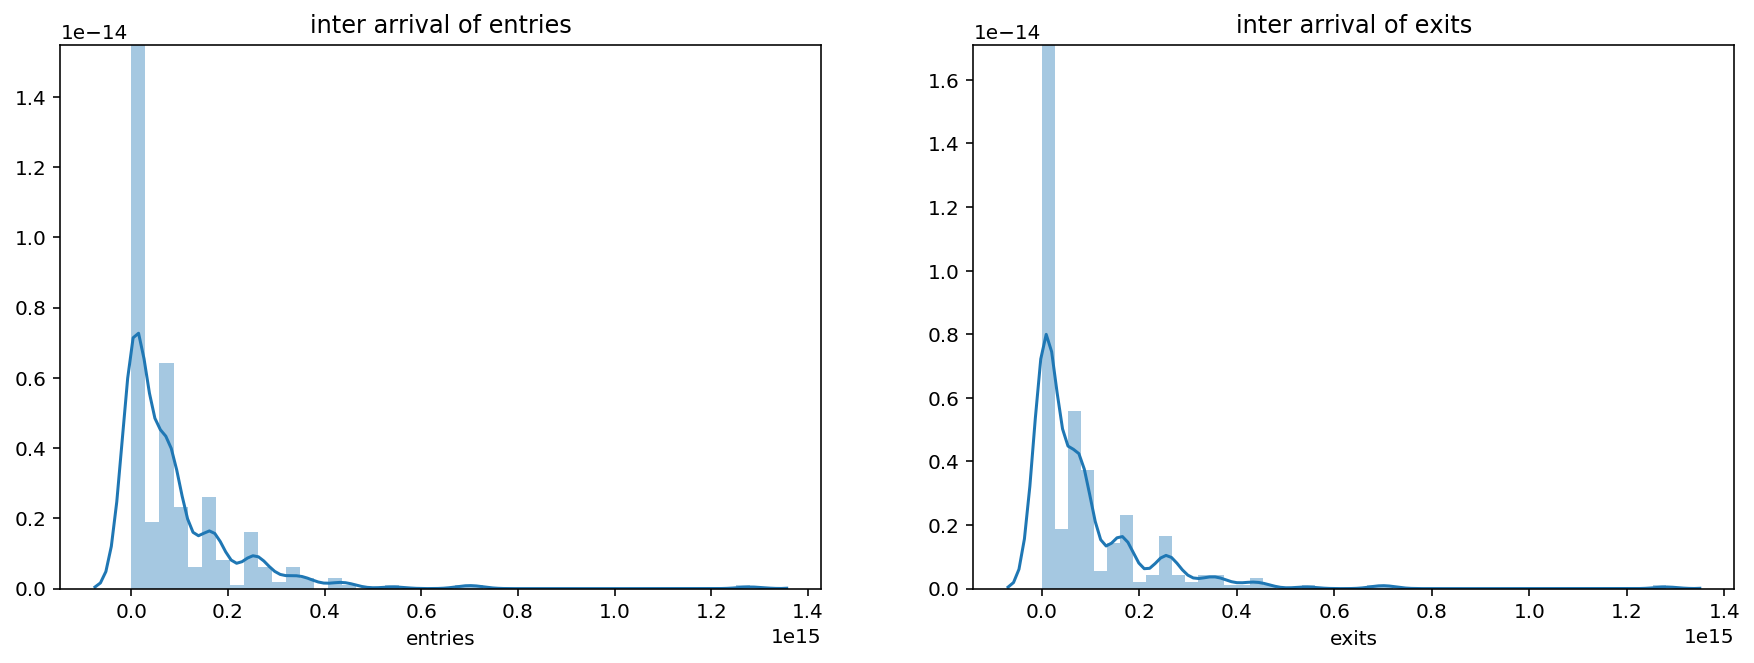

Replaying Queue Request For Payment REJECTED by ADMINISTRATION


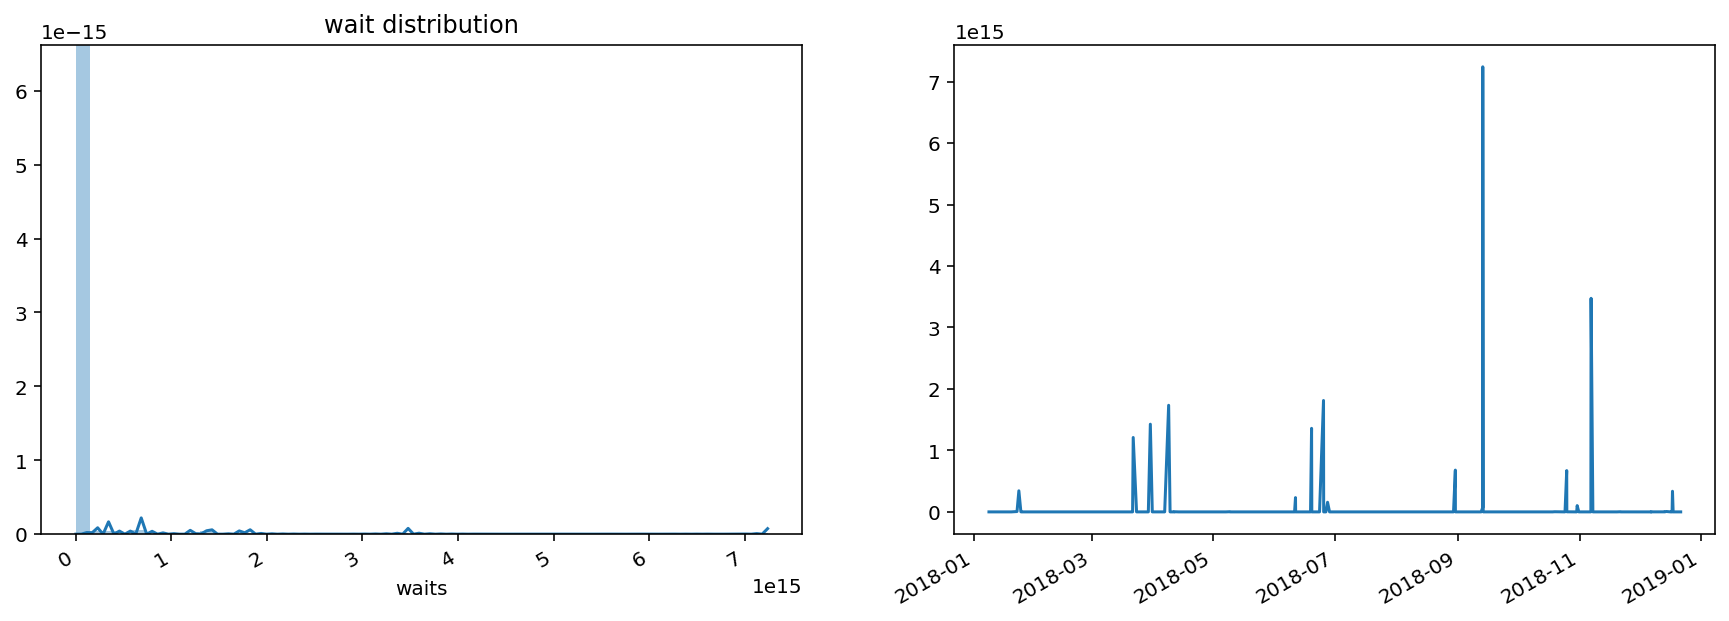

Replaying Queue Request For Payment REJECTED by ADMINISTRATION
Fitted cauchy distribution with error=5.376195473781869e-10)
Fitted chi2 distribution with error=1.7691360248480827e-10)
Fitted expon distribution with error=3.524786770986641e-10)
Fitted exponpow distribution with error=4.2392896180513394e-10)
Fitted gamma distribution with error=6.407399876650245e-10)
Fitted lognorm distribution with error=9.090138526665862e-11)
Fitted norm distribution with error=6.616738771734672e-10)
Fitted powerlaw distribution with error=3.534970440055999e-10)
Fitted rayleigh distribution with error=6.205174787252573e-10)
Fitted uniform distribution with error=8.527965552611743e-10)
          sumsquare_error          aic          bic  kl_div
lognorm      9.090139e-11  3181.455036 -9885.466929     inf
chi2         1.769136e-10  3400.477197 -9657.733831     inf
expon        3.524787e-10  3740.694205 -9427.818248     inf
powerlaw     3.534970e-10  2949.734191 -9420.996769     inf
exponpow     4.239290e-

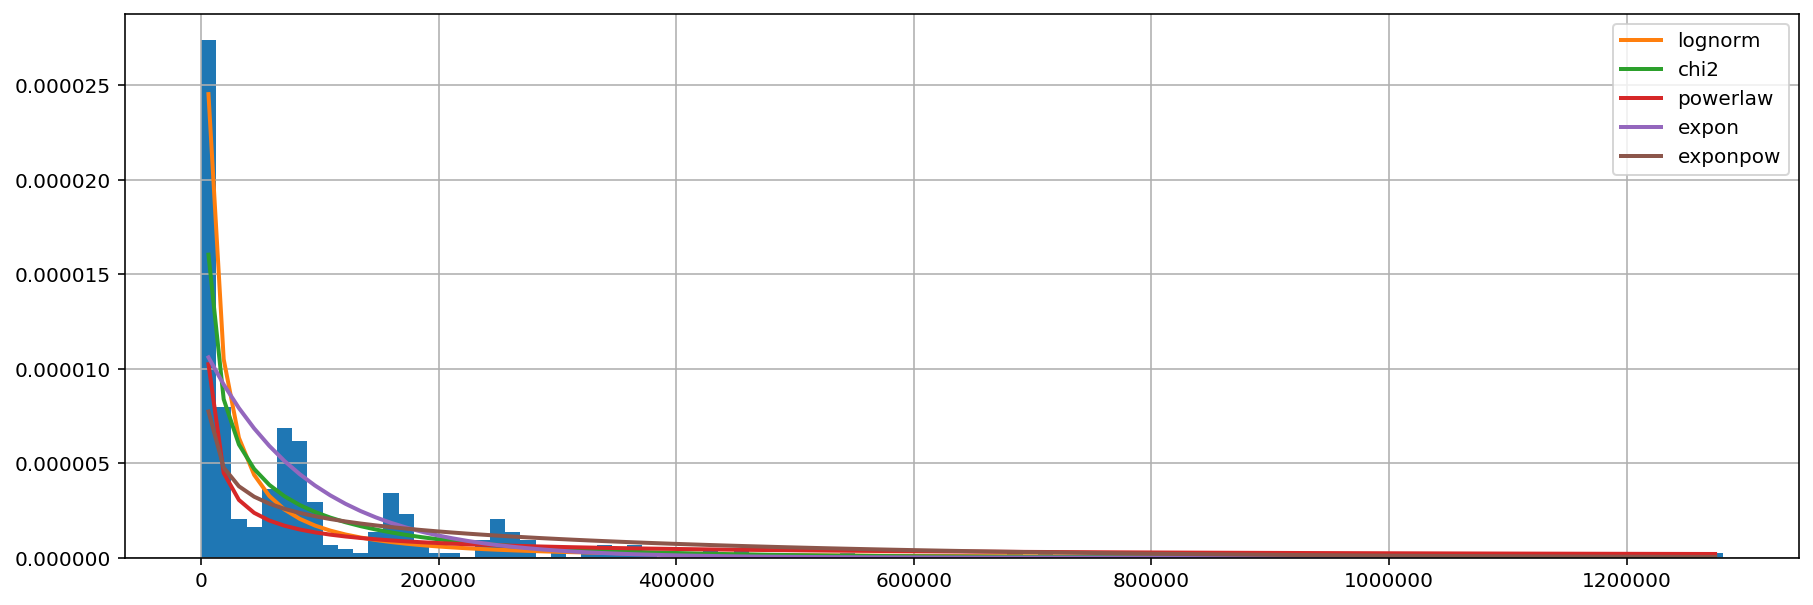

Replaying Queue Request For Payment REJECTED by ADMINISTRATION
Fitted cauchy distribution with error=1.732878319093914e-10)
Fitted chi2 distribution with error=1.310681383514359e-10)
Fitted expon distribution with error=2.6277770941035423e-11)
Fitted exponpow distribution with error=1.42892968560558e-10)
Fitted gamma distribution with error=1.4760321715847217e-10)
Fitted lognorm distribution with error=1.469463734805827e-10)
Fitted norm distribution with error=1.5549051155352273e-10)
Fitted powerlaw distribution with error=1.4222638394099784e-10)
Fitted rayleigh distribution with error=1.486217973512753e-10)
Fitted uniform distribution with error=1.715272609105772e-10)
          sumsquare_error           aic           bic  kl_div
expon        2.627777e-11  13712.282799 -10346.934209     inf
chi2         1.310681e-10   3710.717774  -9789.897551     inf
powerlaw     1.422264e-10   3268.574202  -9761.873521     inf
exponpow     1.428930e-10   3596.429805  -9760.269709     inf
lognorm     

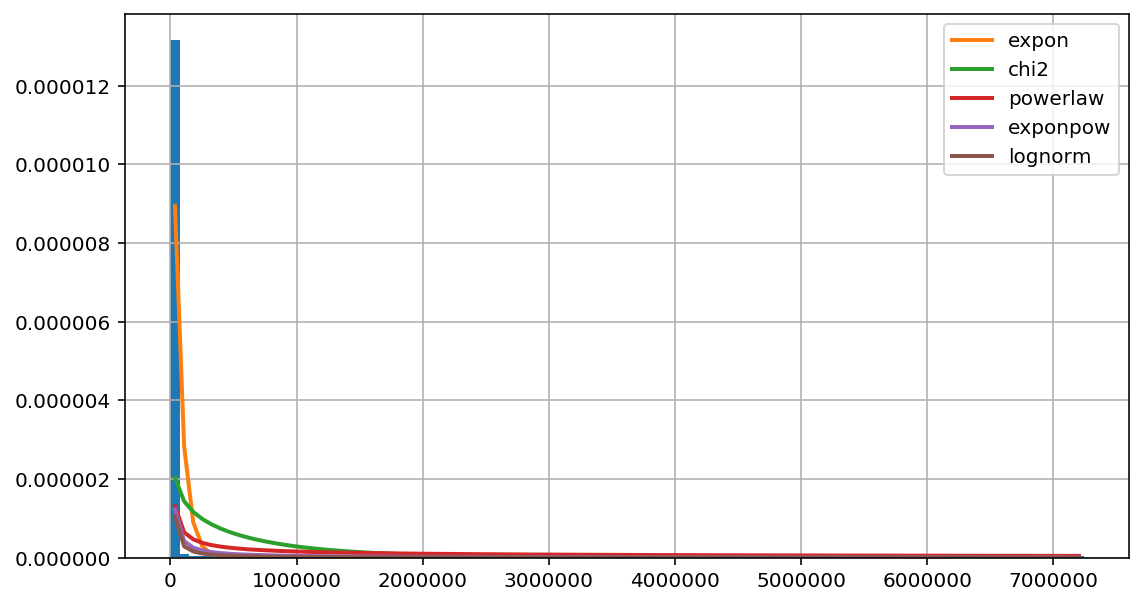

log likelihood -133.07718870496387
log likelihood -131.90702449410193


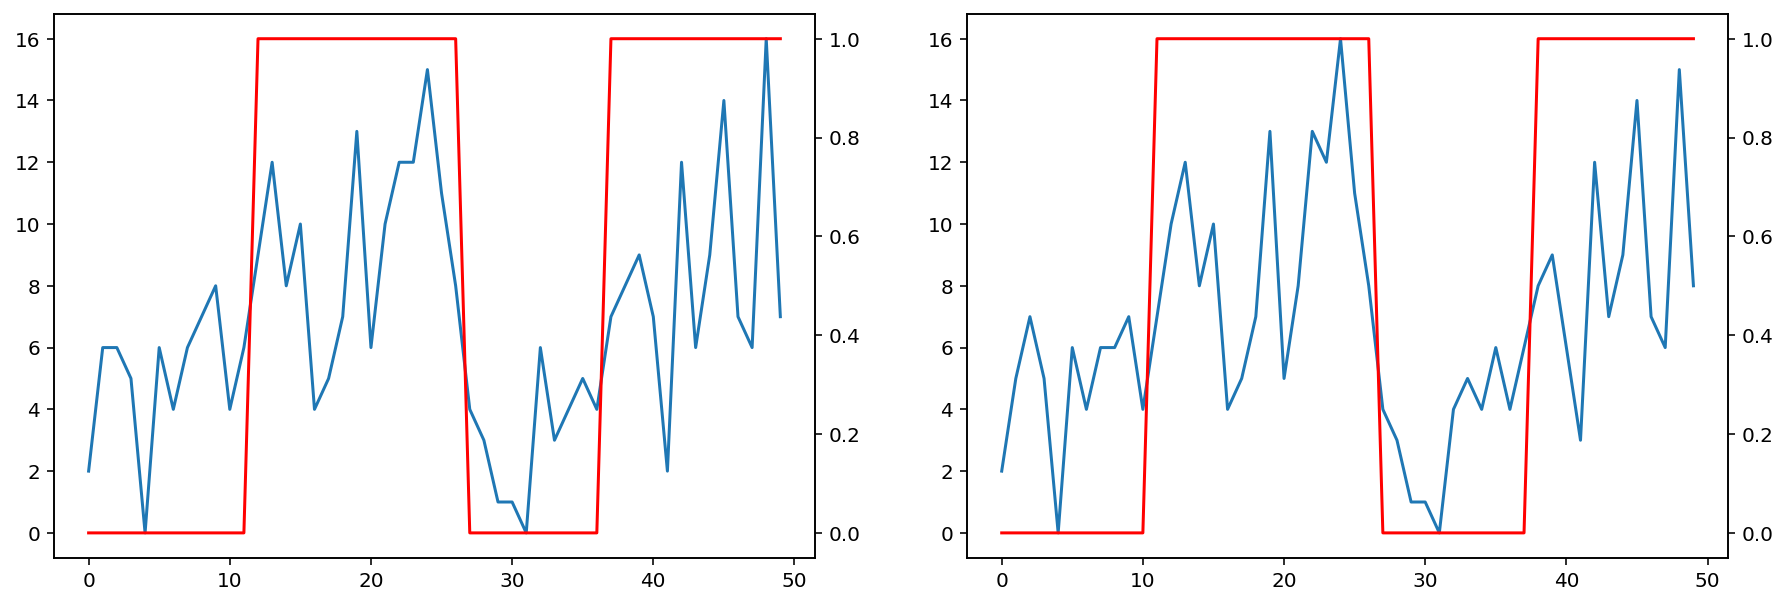

In [55]:
for a in activities[2:3]:
    q = queues[a]
    vis_queue(q)
    vis_iat(q)
    vis_waits(q)
    fit_iat(q)
    fit_waits(q)
    agg_hmm(q)
    

In [56]:
a = 'Request For Payment FINAL_APPROVED by SUPERVISOR'

In [57]:
freq = 'W'
df = queues[a].get_data()
entry_ts = pd.DataFrame(index=pd.DatetimeIndex(pd.to_datetime(df.entries, utc=True)), data={'sources': df.sources.values}).groupby(pd.Grouper(freq=freq)).size()
entry_ts.sort_index(inplace=True)
exits_ts = pd.DataFrame(index=pd.DatetimeIndex(pd.to_datetime(df.exits, utc=True)), data={'resources': df.resources.values}).groupby(pd.Grouper(freq=freq)).size()
exits_ts.sort_index(inplace=True)

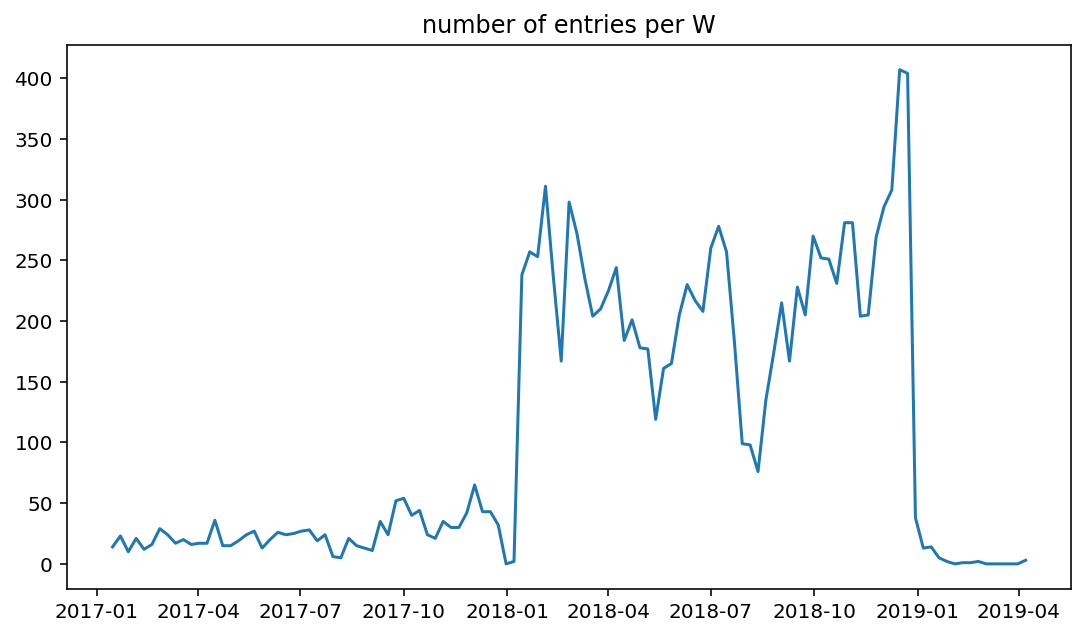

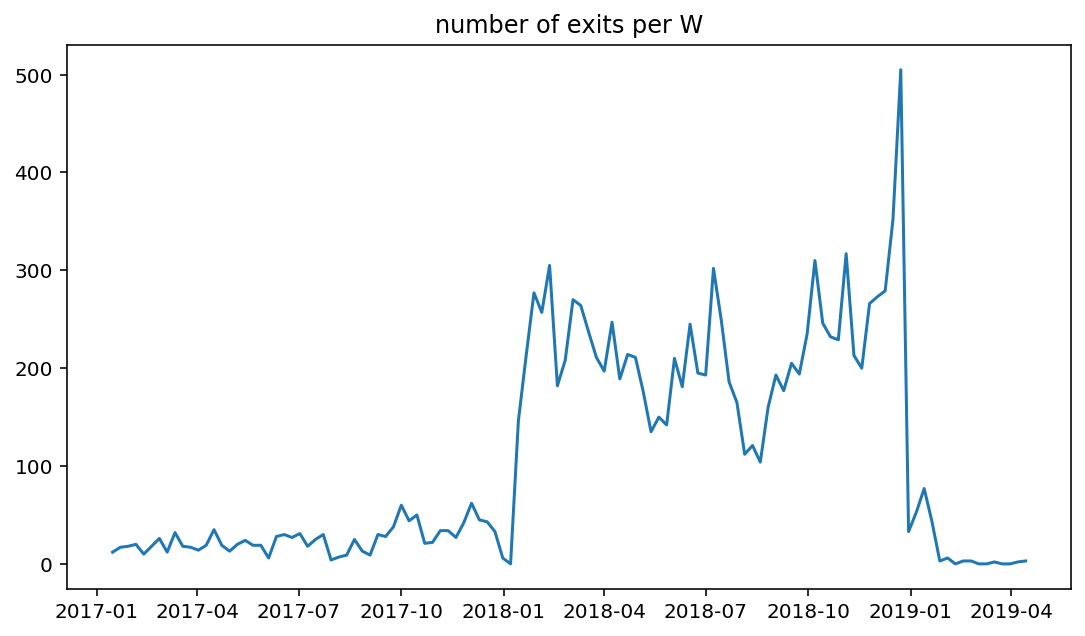

In [58]:
plt.plot(entry_ts)
plt.title('number of entries per %s' % freq)
plt.show()
plt.plot(exits_ts)
plt.title('number of exits per %s' % freq)
plt.show()

In [59]:
waits_ts = pd.Series(index=pd.DatetimeIndex(pd.to_datetime(df.exits, utc=True)), data=df.waits.values)#.groupby(pd.Grouper(freq='W')).sum()
waits_ts.sort_index(inplace=True)

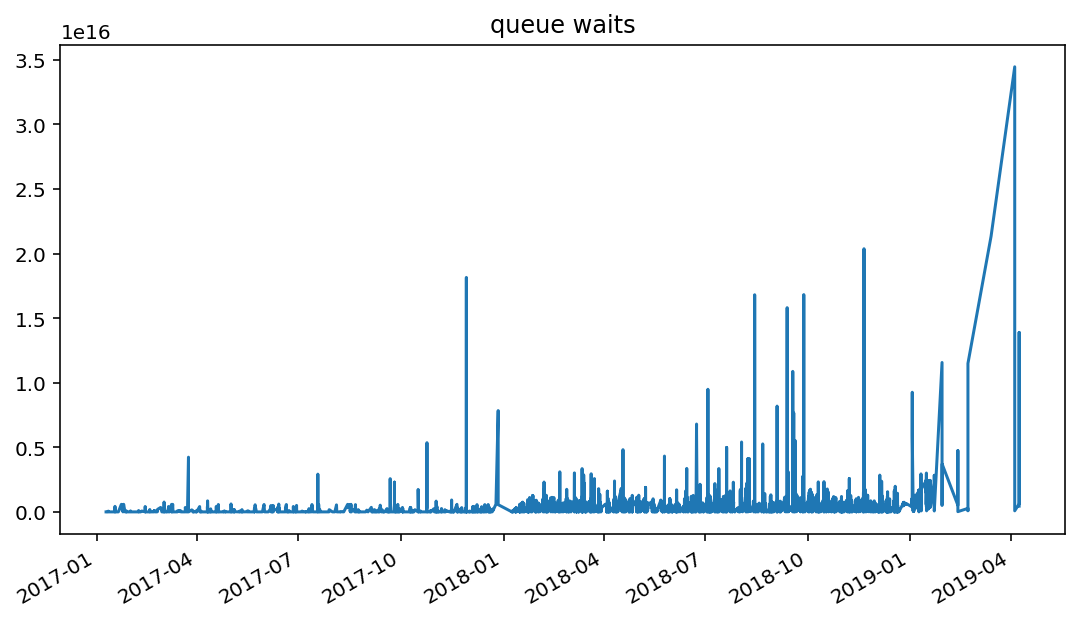

In [60]:
plt.plot(waits_ts)
plt.title('queue waits')
plt.gcf().autofmt_xdate()
plt.show()

In [61]:
ia = queues[a].get_interarrivals()
entry_ia = pd.Series(index=pd.DatetimeIndex(pd.to_datetime(df.entries, utc=True))[:-1], data=ia.entries.values)
entry_ia.sort_index(inplace=True)
exits_ia = pd.Series(index=pd.DatetimeIndex(pd.to_datetime(df.exits, utc=True))[:-1], data=ia.exits.values)
exits_ia.sort_index(inplace=True)

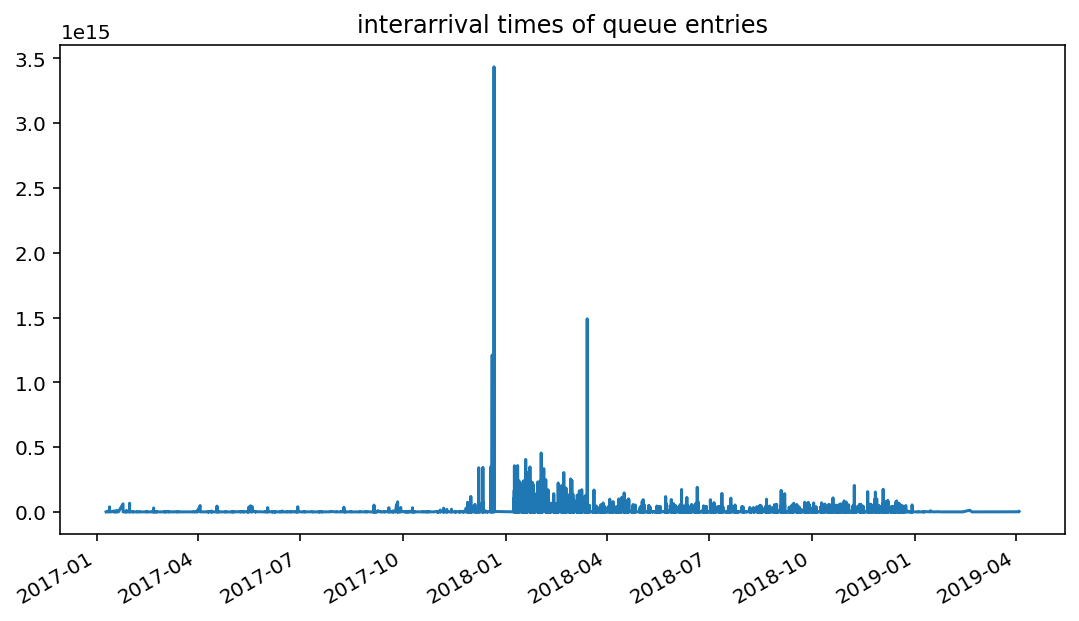

In [62]:
plt.plot(entry_ia)
plt.title('interarrival times of queue entries')
plt.gcf().autofmt_xdate()
plt.show()

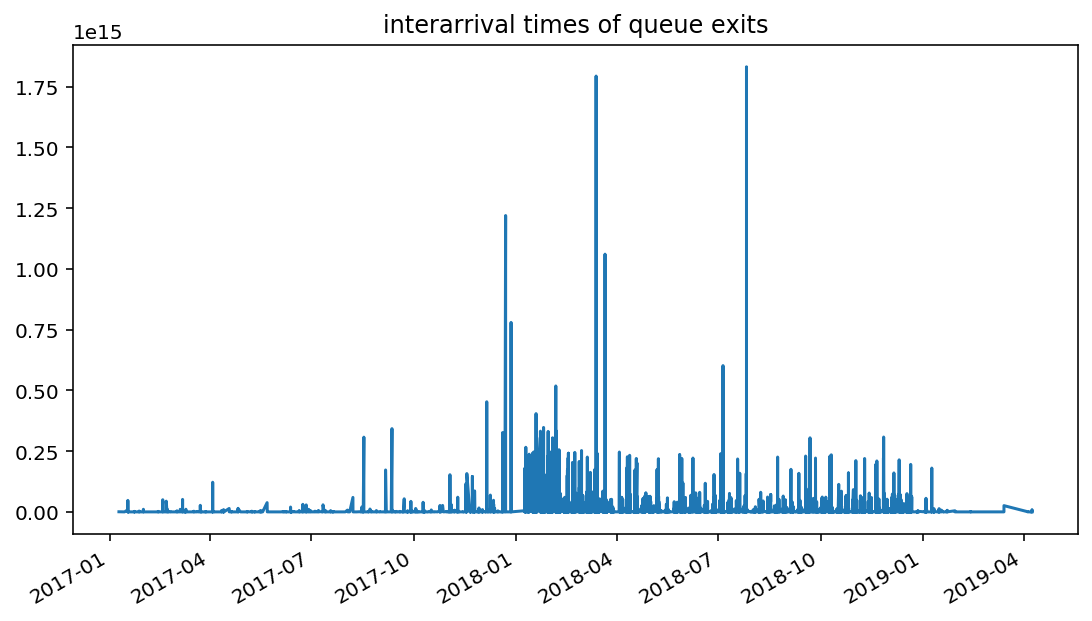

In [63]:
plt.plot(exits_ia)
plt.title('interarrival times of queue exits')
plt.gcf().autofmt_xdate()
plt.show()

                        Unobserved Components Results                         
Dep. Variable:                      y   No. Observations:                  117
Model:                    local level   Log Likelihood                -620.823
Date:                Mon, 18 May 2020   AIC                           1245.646
Time:                        12:02:36   BIC                           1251.153
Sample:                             0   HQIC                          1247.881
                                - 117                                         
Covariance Type:                  opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular     0.0287    372.842    7.7e-05      1.000    -730.729     730.787
sigma2.level      2607.6778    749.811      3.478      0.001    1138.076    4077.280
Ljung-Box (Q):              

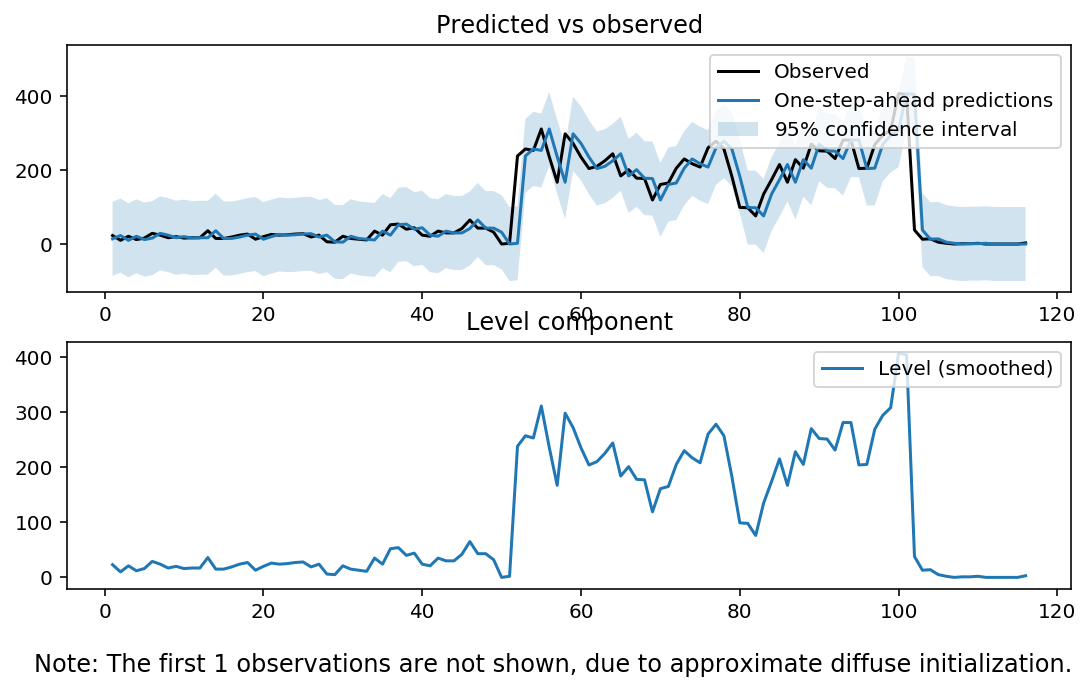

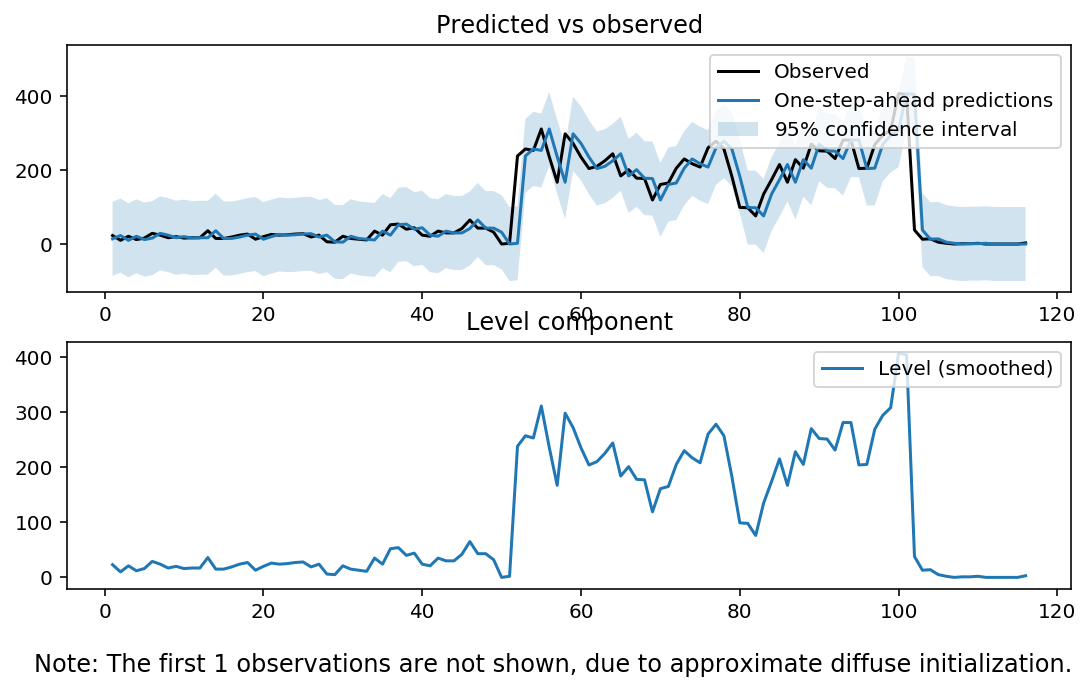

In [64]:
res = sm.tsa.UnobservedComponents(entry_ts.values, 'local level').fit()
print(res.summary())
res.plot_components()

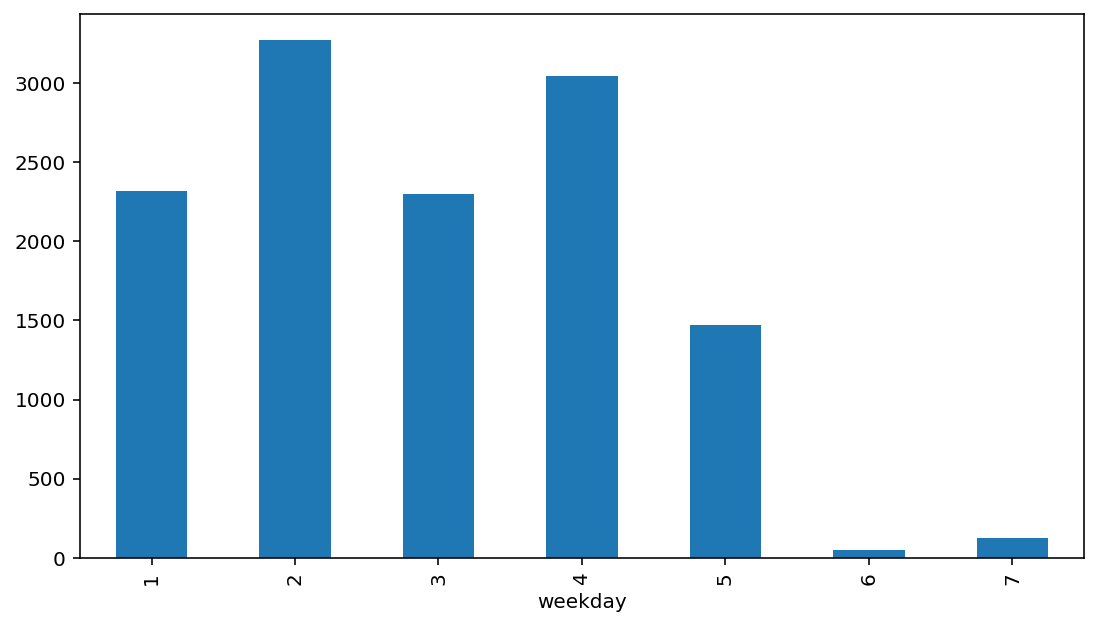

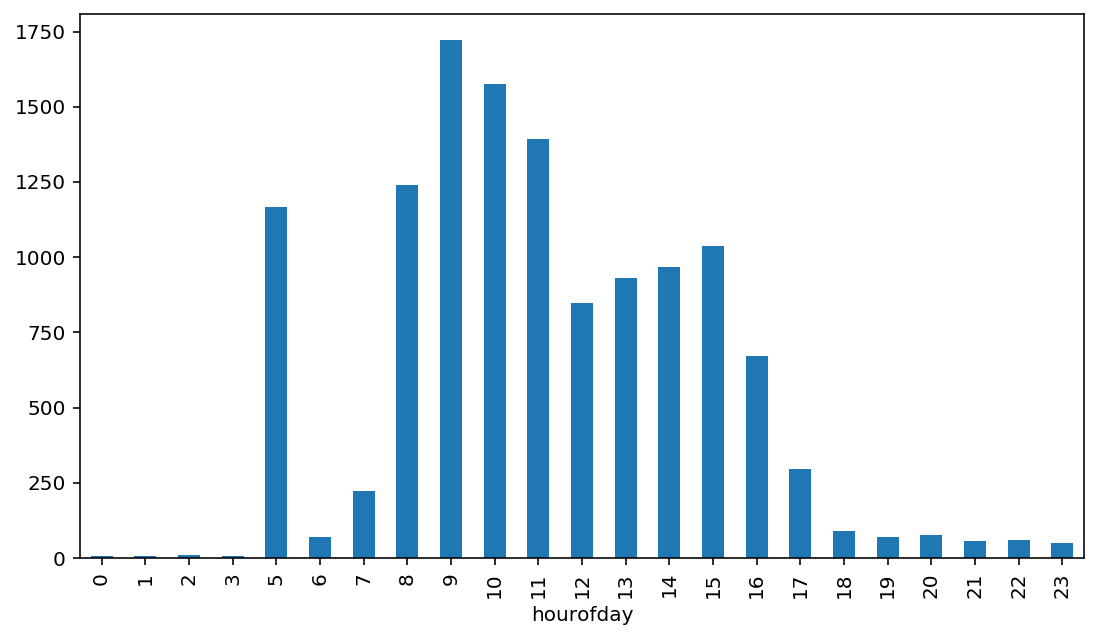

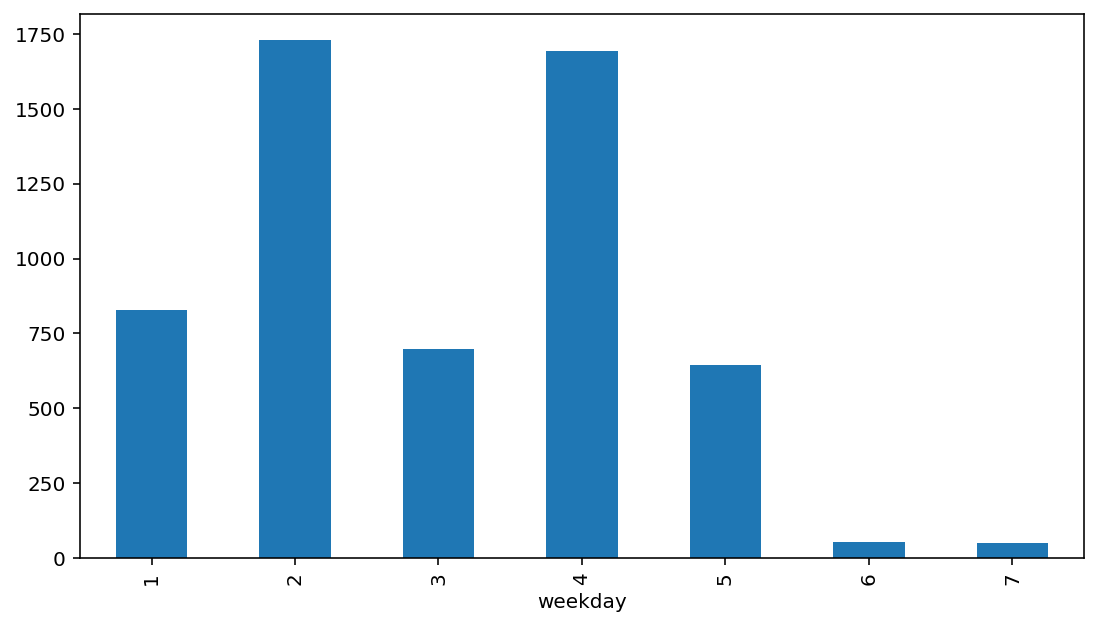

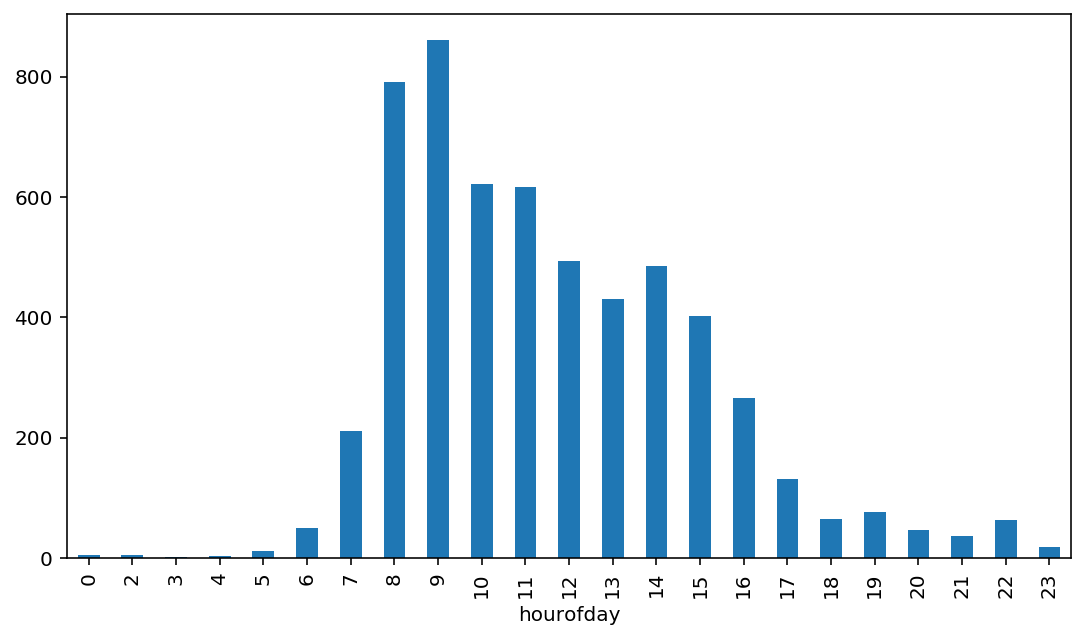

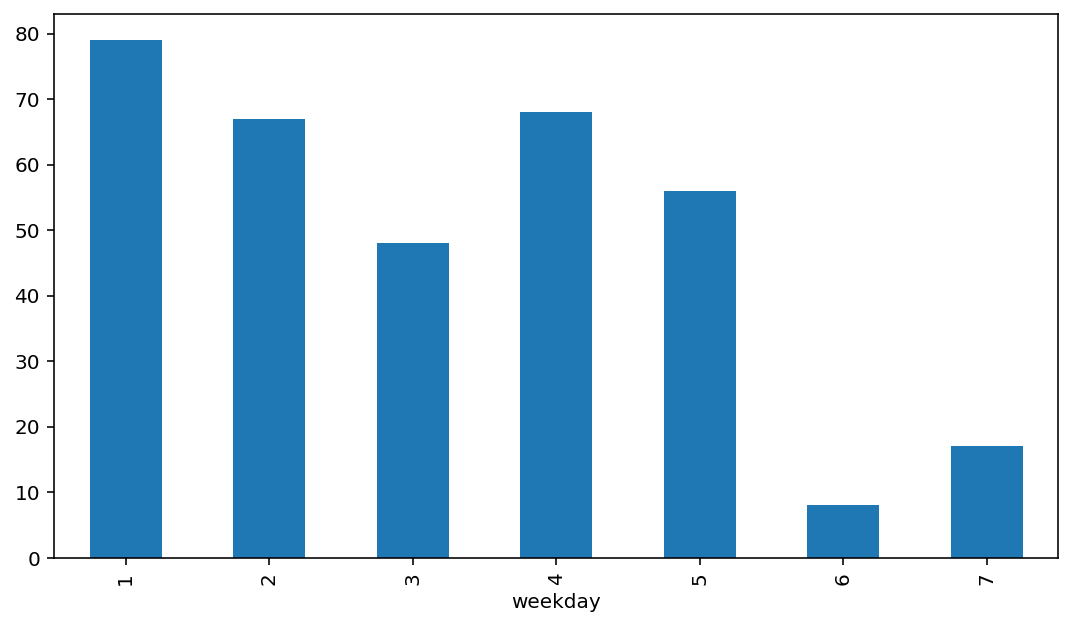

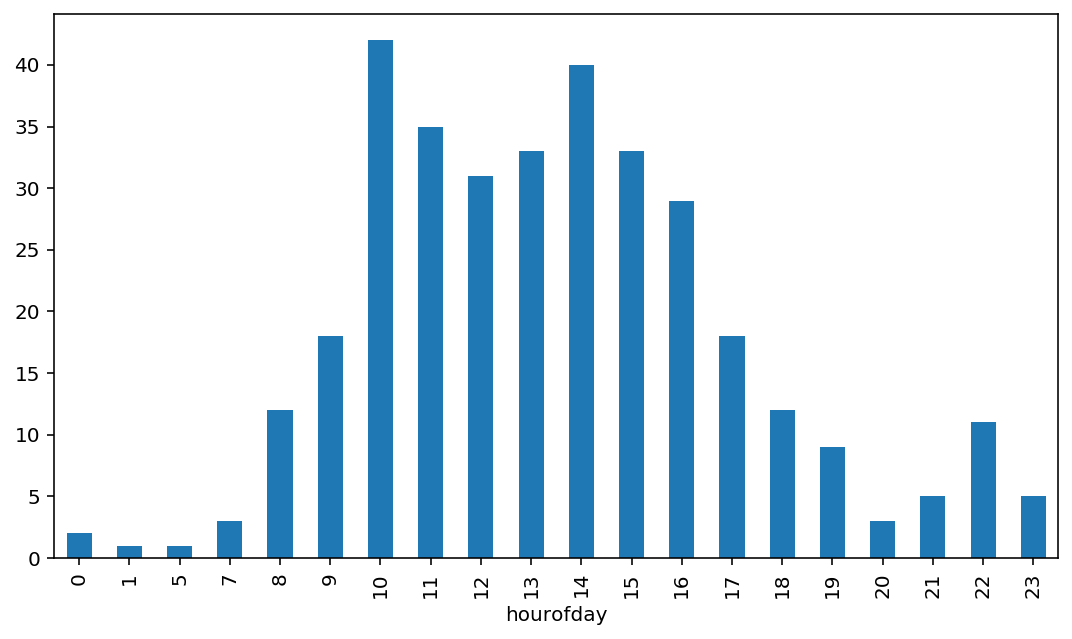

In [65]:
for a in activities[:3]:
    df = queues[a].get_data()
    df = df.sort_values('exits')

    if not df.empty:
        df['weekday'] = df.exits.map(lambda dt: dt.isoweekday())
        df['hourofday'] = df.exits.map(lambda dt: dt.hour)

        df.groupby('weekday').exits.size().plot.bar()
        plt.show()
        df.groupby('hourofday').exits.size().plot.bar()
        plt.show()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:06<00:00, 1595.74draws/s]
The acceptance probability does not match the target. It is 0.8856983641503735, but should be close to 0.8. Try to increase the number of tuning steps.


0.0


C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Ar

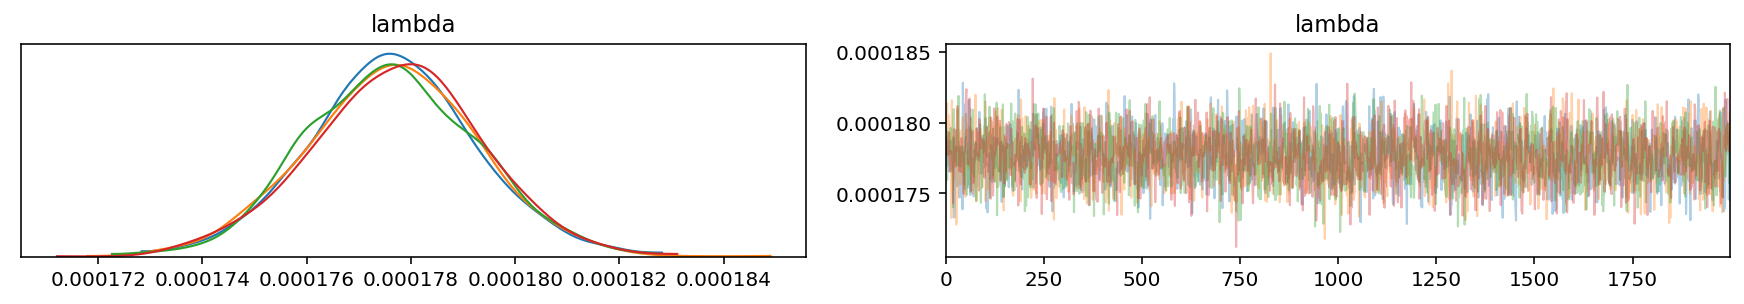

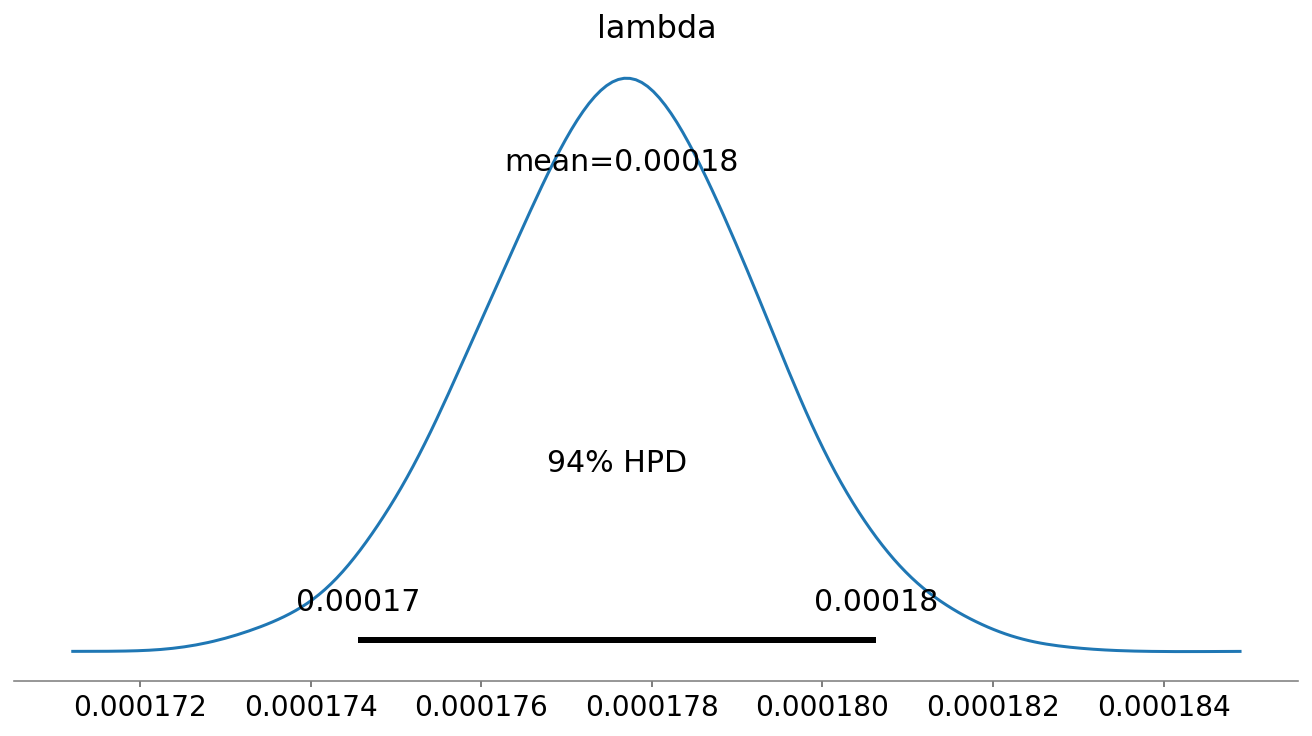

In [66]:
exits_ia_seconds = exits_ia.map(lambda td: td.total_seconds())

with pm.Model() as model_ia:
    lam = pm.Exponential('lambda', exits_ia_seconds.mean())
    p = pm.Exponential('ias', lam=lam, observed=exits_ia_seconds)
    s1 = pm.sample(2000)

print(np.mean(np.exp(s1.get_sampler_stats('model_logp'))))
az.plot_trace(s1)
plt.show()
az.plot_posterior(s1)
plt.show()

In [67]:
1 / np.mean(s1['lambda']), exits_ia_seconds.mean()

(5629.2571965041125, 5630.410262529833)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains, 0 divergences: 100%|██████████| 10000/10000 [00:08<00:00, 1231.62draws/s]
C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
The acceptance probability does not match the target. It is 0.8868872850439792, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9192526738188365, but should be close to 0.8. Try to increase the number of tuning steps.
C:\Users\Daniel\anaconda3\envs\WebMiningAssignments\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_di

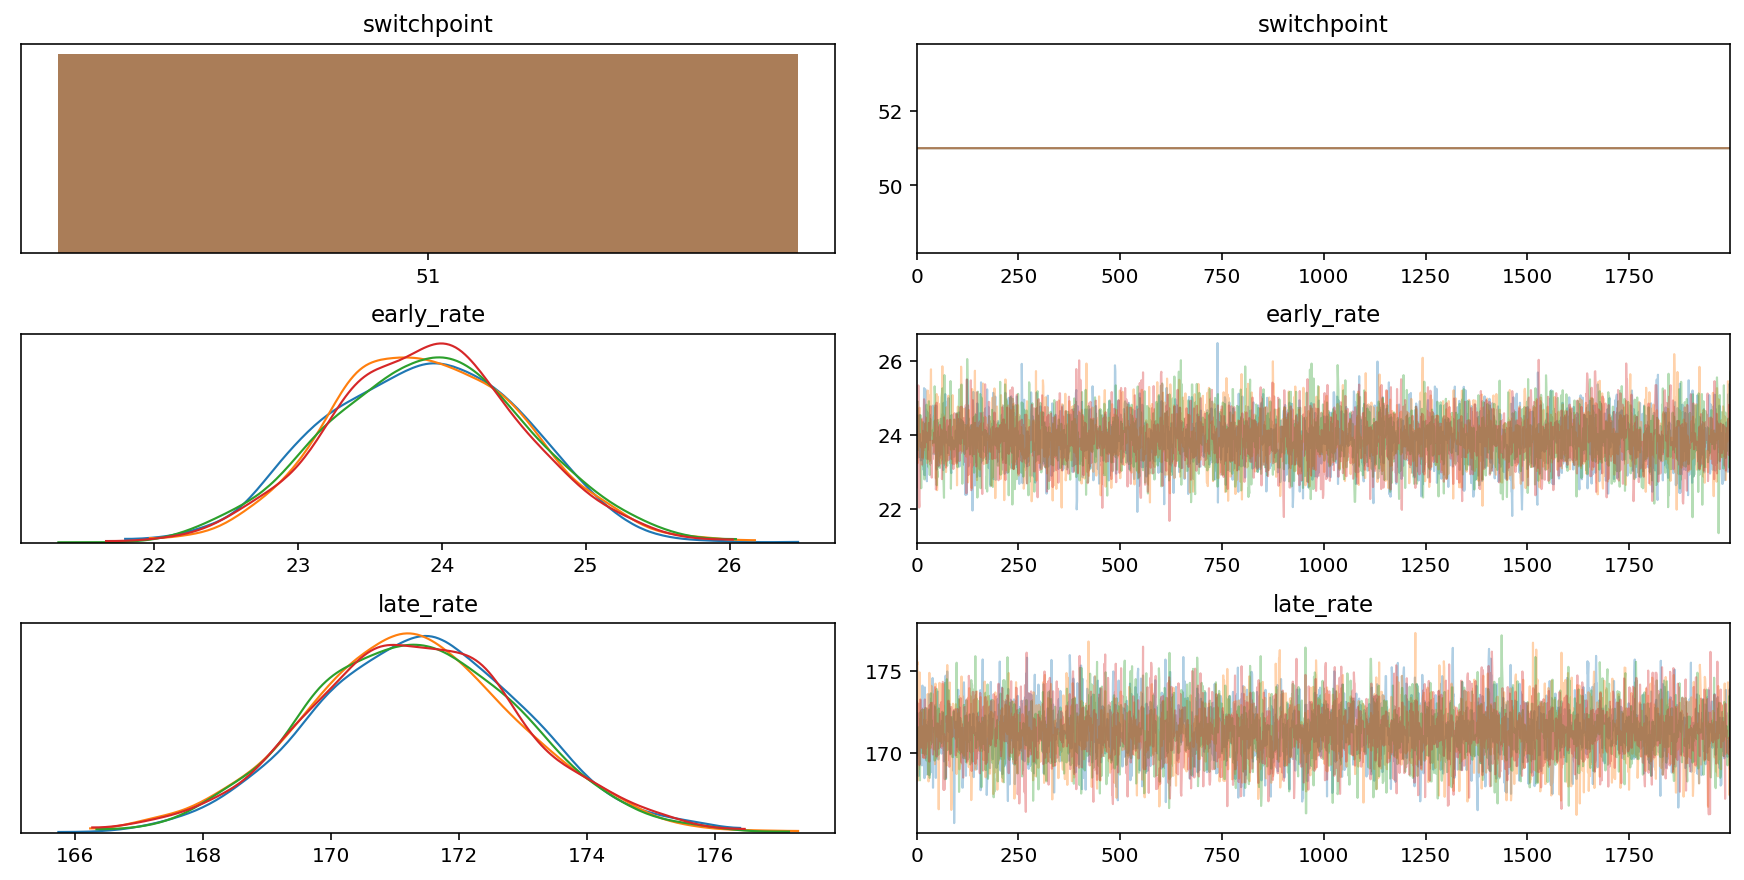

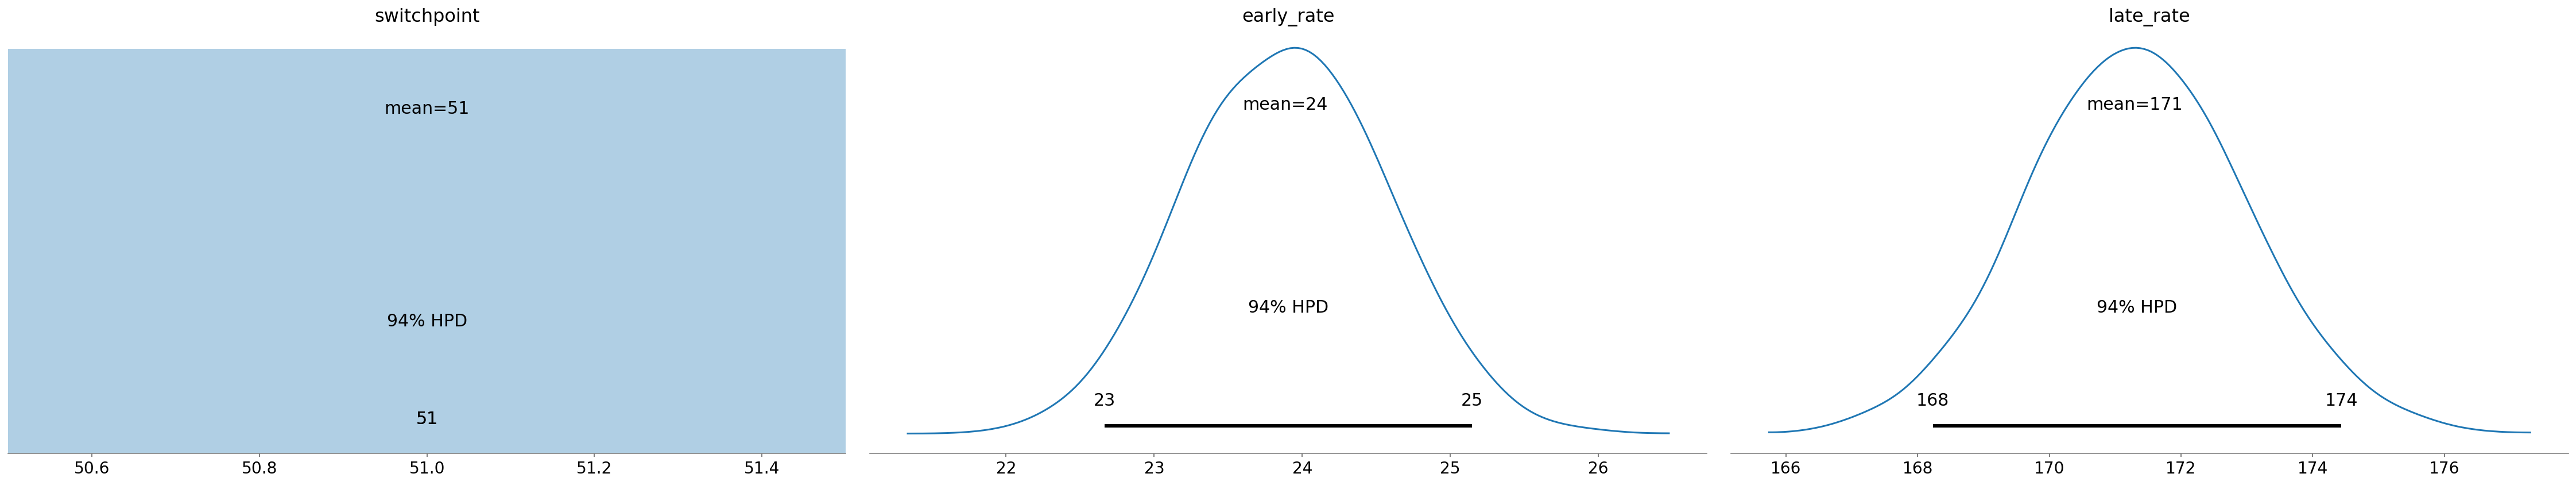

In [68]:
with pm.Model() as model:
    switchpoint = pm.DiscreteUniform('switchpoint', lower=0, upper=len(entry_ts))

    # Priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential('early_rate', 1)
    late_rate = pm.Exponential('late_rate', 1)

    # Allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint >= range(len(entry_ts)), early_rate, late_rate)

    entries_rv = pm.Poisson('entries', rate, observed=entry_ts)

    samples = pm.sample(2000)

az.plot_trace(samples)
plt.show()
az.plot_posterior(samples)
plt.show()

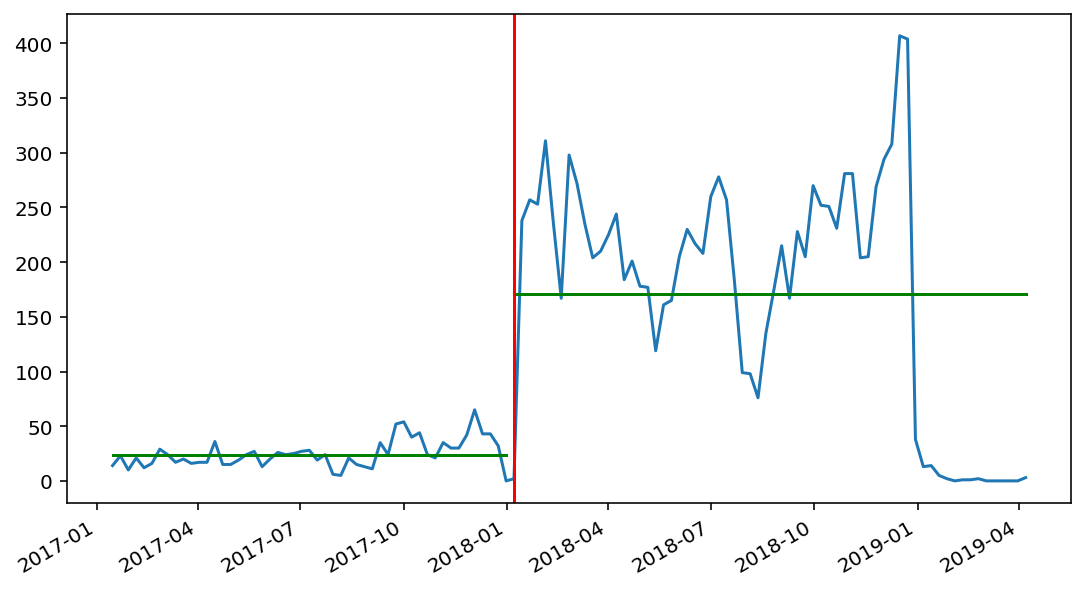

In [69]:
sw_point = int(np.mean(samples['switchpoint']))
early_rt = np.mean(samples['early_rate'])
late_rt = np.mean(samples['late_rate'])

plt.plot(entry_ts)
plt.plot(entry_ts.index[[0, sw_point-1]], [early_rt, early_rt], color='green')
plt.plot(entry_ts.index[[sw_point, len(entry_ts) - 1]], [late_rt, late_rt], color='green')
plt.axvline(entry_ts.index[sw_point], color='red')
plt.gcf().autofmt_xdate()
plt.show()

In [70]:
np.mean(np.exp(samples.get_sampler_stats('model_logp')))

0.0